In [182]:
import pandas as pd
import glob
import cv2
import os
import csv
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score
from keras.layers import Flatten, Dense
from keras.models import Model
from keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from tensorflow.keras import utils
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import keras
from keras import optimizers

In [183]:
#Creating a dataframe out fo our images to use for image recognition

image_direc = 'D:\GIT\classification_project\Personal Projects\moonphaseimages\MoonPhaseImages'

image_data = []

for root, dirs, files in os.walk(image_direc):
    for file in files:
        if file.endswith('.jpg'):
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            image_data.append([image_path, label])

df = pd.DataFrame(image_data, columns =['Image Path', 'Label'])

df.to_csv('image_data.csv', index = False)

In [184]:
df['Image Path'] = df['Image Path'].str.replace('D:\\GIT\\classification_project\\Personal Projects\\moonphaseimages\\MoonPhaseImages\\', '')
df

,Image Path,Label
0,FirstQuarter.jpg,MoonPhaseImages
1,FirstQuarter10.jpg,MoonPhaseImages
2,FirstQuarter11.jpg,MoonPhaseImages
3,FirstQuarter12.jpg,MoonPhaseImages
4,FirstQuarter13.jpg,MoonPhaseImages
...,...,...
141,WaxingGibbous5.jpg,MoonPhaseImages
142,WaxingGibbous6.jpg,MoonPhaseImages
143,WaxingGibbous7.jpg,MoonPhaseImages
144,WaxingGibbous8.jpg,MoonPhaseImages


In [185]:
df['Label'] = df['Image Path']
df

,Image Path,Label
0,FirstQuarter.jpg,FirstQuarter.jpg
1,FirstQuarter10.jpg,FirstQuarter10.jpg
2,FirstQuarter11.jpg,FirstQuarter11.jpg
3,FirstQuarter12.jpg,FirstQuarter12.jpg
4,FirstQuarter13.jpg,FirstQuarter13.jpg
...,...,...
141,WaxingGibbous5.jpg,WaxingGibbous5.jpg
142,WaxingGibbous6.jpg,WaxingGibbous6.jpg
143,WaxingGibbous7.jpg,WaxingGibbous7.jpg
144,WaxingGibbous8.jpg,WaxingGibbous8.jpg


In [186]:
df['Label'] = df['Label'].str.replace('.jpg', '')
df

,Image Path,Label
0,FirstQuarter.jpg,FirstQuarter
1,FirstQuarter10.jpg,FirstQuarter10
2,FirstQuarter11.jpg,FirstQuarter11
3,FirstQuarter12.jpg,FirstQuarter12
4,FirstQuarter13.jpg,FirstQuarter13
...,...,...
141,WaxingGibbous5.jpg,WaxingGibbous5
142,WaxingGibbous6.jpg,WaxingGibbous6
143,WaxingGibbous7.jpg,WaxingGibbous7
144,WaxingGibbous8.jpg,WaxingGibbous8


In [187]:
#Using regex to elimate all numbers to better differentiate class values.

df['Label'] = df['Label'].str.replace(r'\d+$', '', regex=True)
df['Label'].value_counts()

Label
Full              41
WaxingCrescent    39
WaningGibbous     28
WaxingGibbous     22
FirstQuarter      16
Name: count, dtype: int64

In [188]:
df

,Image Path,Label
0,FirstQuarter.jpg,FirstQuarter
1,FirstQuarter10.jpg,FirstQuarter
2,FirstQuarter11.jpg,FirstQuarter
3,FirstQuarter12.jpg,FirstQuarter
4,FirstQuarter13.jpg,FirstQuarter
...,...,...
141,WaxingGibbous5.jpg,WaxingGibbous
142,WaxingGibbous6.jpg,WaxingGibbous
143,WaxingGibbous7.jpg,WaxingGibbous
144,WaxingGibbous8.jpg,WaxingGibbous


## Exploration


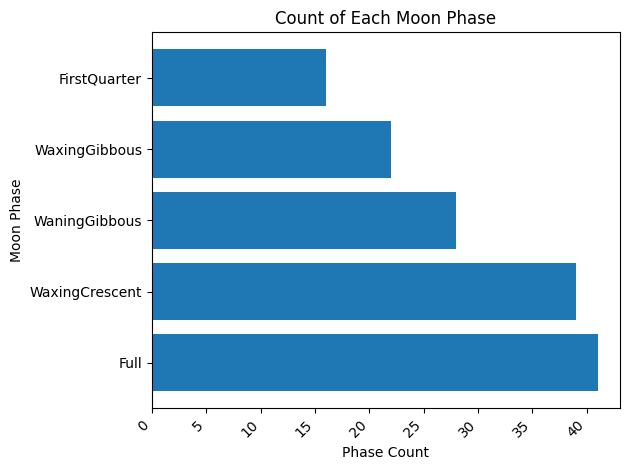

In [189]:
fig, ax = plt.subplots()

type = df['Label'].value_counts()
bar_labels = df['Label'].unique()

ax.barh(type.index, type.values)

ax.set_xlabel('Phase Count')
ax.set_ylabel('Moon Phase')
ax.set_title('Count of Each Moon Phase')

plt.xticks(rotation = 45, ha= 'right') #rotating labels
plt.tight_layout() #adjusting layout 
plt.show()

## Creating Array for Images

In [190]:
moon_phases = os.listdir('D:\GIT\classification_project\Personal Projects\moonphaseimages\MoonPhaseImages')

array_jpg = []
name_jpg = []

for phase in (moon_phases):
    if phase.endswith('.jpg'):
        name_jpg.append(phase)

        loaded_phases = image.load_img(r'D:\GIT\classification_project\Personal Projects\moonphaseimages\MoonPhaseImages' + '\\' + phase, target_size = (128, 128))
        array_jpg.append(image.img_to_array(loaded_phases)/255)

In [191]:
name_jpg

['FirstQuarter.jpg',
 'FirstQuarter10.jpg',
 'FirstQuarter11.jpg',
 'FirstQuarter12.jpg',
 'FirstQuarter13.jpg',
 'FirstQuarter14.jpg',
 'FirstQuarter15.jpg',
 'FirstQuarter16.jpg',
 'FirstQuarter2.jpg',
 'FirstQuarter3.jpg',
 'FirstQuarter4.jpg',
 'FirstQuarter5.jpg',
 'FirstQuarter6.jpg',
 'FirstQuarter7.jpg',
 'FirstQuarter8.jpg',
 'FirstQuarter9.jpg',
 'Full1.jpg',
 'Full10.jpg',
 'Full11.jpg',
 'Full12.jpg',
 'Full13.jpg',
 'Full14.jpg',
 'Full15.jpg',
 'Full16.jpg',
 'Full18.jpg',
 'Full19.jpg',
 'Full2.jpg',
 'Full20.jpg',
 'Full21.jpg',
 'Full22.jpg',
 'Full23.jpg',
 'Full24.jpg',
 'Full25.jpg',
 'Full26.jpg',
 'Full27.jpg',
 'Full28.jpg',
 'Full29.jpg',
 'Full3.jpg',
 'Full30.jpg',
 'Full31.jpg',
 'Full32.jpg',
 'Full33.jpg',
 'Full34.jpg',
 'Full35.jpg',
 'Full36.jpg',
 'Full37.jpg',
 'Full38.jpg',
 'Full39.jpg',
 'Full4.jpg',
 'Full40.jpg',
 'Full41.jpg',
 'Full42.jpg',
 'Full43.jpg',
 'Full5.jpg',
 'Full6.jpg',
 'Full7.jpg',
 'Full9.jpg',
 'WaningGibbous.jpg',
 'WaningGibbo

In [192]:
array_jpg

[array([[[0.00392157, 0.01568628, 0.04313726],
         [0.01176471, 0.03137255, 0.05490196],
         [0.02745098, 0.04705882, 0.07058824],
         ...,
         [0.01568628, 0.04313726, 0.06666667],
         [0.02352941, 0.05098039, 0.07450981],
         [0.05098039, 0.07843138, 0.10196079]],
 
        [[0.01568628, 0.03529412, 0.05882353],
         [0.01176471, 0.03137255, 0.05490196],
         [0.03529412, 0.05490196, 0.07843138],
         ...,
         [0.01568628, 0.04313726, 0.07450981],
         [0.        , 0.02745098, 0.06666667],
         [0.03921569, 0.06666667, 0.09019608]],
 
        [[0.01568628, 0.03529412, 0.05882353],
         [0.01176471, 0.03137255, 0.05490196],
         [0.01960784, 0.04705882, 0.07058824],
         ...,
         [0.01176471, 0.03921569, 0.07843138],
         [0.02352941, 0.05098039, 0.09019608],
         [0.05098039, 0.07843138, 0.11764706]],
 
        ...,
 
        [[0.02745098, 0.02745098, 0.05882353],
         [0.03137255, 0.03137255, 0.06274

## Array / DataFrame

In [193]:
np_array = np.array(array_jpg)
np_array

array([[[[0.00392157, 0.01568628, 0.04313726],
         [0.01176471, 0.03137255, 0.05490196],
         [0.02745098, 0.04705882, 0.07058824],
         ...,
         [0.01568628, 0.04313726, 0.06666667],
         [0.02352941, 0.05098039, 0.07450981],
         [0.05098039, 0.07843138, 0.10196079]],

        [[0.01568628, 0.03529412, 0.05882353],
         [0.01176471, 0.03137255, 0.05490196],
         [0.03529412, 0.05490196, 0.07843138],
         ...,
         [0.01568628, 0.04313726, 0.07450981],
         [0.        , 0.02745098, 0.06666667],
         [0.03921569, 0.06666667, 0.09019608]],

        [[0.01568628, 0.03529412, 0.05882353],
         [0.01176471, 0.03137255, 0.05490196],
         [0.01960784, 0.04705882, 0.07058824],
         ...,
         [0.01176471, 0.03921569, 0.07843138],
         [0.02352941, 0.05098039, 0.09019608],
         [0.05098039, 0.07843138, 0.11764706]],

        ...,

        [[0.02745098, 0.02745098, 0.05882353],
         [0.03137255, 0.03137255, 0.0627451 ]

In [194]:
flattened_array = np_array.reshape(np_array.shape[0], -1)
flattened_array.shape

(146, 49152)

In [195]:
moon_df = pd.DataFrame(flattened_array)
moon_df

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,0.003922,0.015686,0.043137,0.011765,0.031373,0.054902,0.027451,0.047059,0.070588,0.007843,...,0.098039,0.043137,0.078431,0.113725,0.027451,0.054902,0.094118,0.019608,0.035294,0.078431
1,0.474510,0.639216,0.874510,0.482353,0.647059,0.882353,0.490196,0.654902,0.890196,0.470588,...,0.133333,0.023529,0.054902,0.098039,0.027451,0.058824,0.101961,0.031373,0.062745,0.105882
2,0.184314,0.266667,0.349020,0.188235,0.270588,0.352941,0.184314,0.266667,0.349020,0.188235,...,0.035294,0.023529,0.027451,0.035294,0.023529,0.027451,0.035294,0.015686,0.019608,0.027451
3,0.011765,0.011765,0.003922,0.007843,0.007843,0.000000,0.000000,0.000000,0.000000,0.015686,...,0.047059,0.062745,0.062745,0.054902,0.043137,0.043137,0.035294,0.054902,0.054902,0.047059
4,0.007843,0.007843,0.007843,0.003922,0.003922,0.003922,0.007843,0.007843,0.007843,0.003922,...,0.031373,0.023529,0.031373,0.027451,0.015686,0.023529,0.019608,0.039216,0.047059,0.043137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.011765,0.011765,0.011765,0.015686,0.015686,0.015686,0.011765,0.011765,0.011765,0.011765,...,0.007843,0.011765,0.011765,0.011765,0.000000,0.000000,0.000000,0.019608,0.019608,0.019608
142,0.050980,0.050980,0.050980,0.011765,0.011765,0.011765,0.003922,0.003922,0.003922,0.015686,...,0.000000,0.011765,0.011765,0.011765,0.000000,0.000000,0.000000,0.011765,0.011765,0.011765
143,0.133333,0.231373,0.388235,0.156863,0.258824,0.403922,0.141176,0.243137,0.388235,0.145098,...,0.498039,0.188235,0.309804,0.490196,0.200000,0.321569,0.501961,0.184314,0.305882,0.486275
144,0.478431,0.549020,0.643137,0.478431,0.549020,0.643137,0.474510,0.545098,0.639216,0.482353,...,0.109804,0.054902,0.090196,0.125490,0.023529,0.058824,0.094118,0.035294,0.070588,0.105882


In [196]:
moon_phases_df = pd.concat([moon_df, df], axis = 1)
moon_phases_df

,0,1,2,3,4,5,6,7,8,9,...,49144,49145,49146,49147,49148,49149,49150,49151,Image Path,Label
0,0.003922,0.015686,0.043137,0.011765,0.031373,0.054902,0.027451,0.047059,0.070588,0.007843,...,0.078431,0.113725,0.027451,0.054902,0.094118,0.019608,0.035294,0.078431,FirstQuarter.jpg,FirstQuarter
1,0.474510,0.639216,0.874510,0.482353,0.647059,0.882353,0.490196,0.654902,0.890196,0.470588,...,0.054902,0.098039,0.027451,0.058824,0.101961,0.031373,0.062745,0.105882,FirstQuarter10.jpg,FirstQuarter
2,0.184314,0.266667,0.349020,0.188235,0.270588,0.352941,0.184314,0.266667,0.349020,0.188235,...,0.027451,0.035294,0.023529,0.027451,0.035294,0.015686,0.019608,0.027451,FirstQuarter11.jpg,FirstQuarter
3,0.011765,0.011765,0.003922,0.007843,0.007843,0.000000,0.000000,0.000000,0.000000,0.015686,...,0.062745,0.054902,0.043137,0.043137,0.035294,0.054902,0.054902,0.047059,FirstQuarter12.jpg,FirstQuarter
4,0.007843,0.007843,0.007843,0.003922,0.003922,0.003922,0.007843,0.007843,0.007843,0.003922,...,0.031373,0.027451,0.015686,0.023529,0.019608,0.039216,0.047059,0.043137,FirstQuarter13.jpg,FirstQuarter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0.011765,0.011765,0.011765,0.015686,0.015686,0.015686,0.011765,0.011765,0.011765,0.011765,...,0.011765,0.011765,0.000000,0.000000,0.000000,0.019608,0.019608,0.019608,WaxingGibbous5.jpg,WaxingGibbous
142,0.050980,0.050980,0.050980,0.011765,0.011765,0.011765,0.003922,0.003922,0.003922,0.015686,...,0.011765,0.011765,0.000000,0.000000,0.000000,0.011765,0.011765,0.011765,WaxingGibbous6.jpg,WaxingGibbous
143,0.133333,0.231373,0.388235,0.156863,0.258824,0.403922,0.141176,0.243137,0.388235,0.145098,...,0.309804,0.490196,0.200000,0.321569,0.501961,0.184314,0.305882,0.486275,WaxingGibbous7.jpg,WaxingGibbous
144,0.478431,0.549020,0.643137,0.478431,0.549020,0.643137,0.474510,0.545098,0.639216,0.482353,...,0.090196,0.125490,0.023529,0.058824,0.094118,0.035294,0.070588,0.105882,WaxingGibbous8.jpg,WaxingGibbous


In [197]:
moon_encoded = pd.get_dummies(df, columns = ['Label'])
moon_encoded[['Label_FirstQuarter','Label_Full','Label_WaningGibbous','Label_WaxingCrescent','Label_WaxingGibbous']].astype(int)

,Label_FirstQuarter,Label_Full,Label_WaningGibbous,Label_WaxingCrescent,Label_WaxingGibbous
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
141,0,0,0,0,1
142,0,0,0,0,1
143,0,0,0,0,1
144,0,0,0,0,1


In [198]:
x = np_array.reshape(np_array.shape[0], 128, 128, 3)
y = moon_encoded.drop(['Image Path'], axis = 1)
x.shape, y.shape

((146, 128, 128, 3), (146, 5))

In [199]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.25)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

((109, 128, 128, 3), (37, 128, 128, 3), (109, 5), (37, 5))

## Modelling

In [200]:
model = Sequential()
model.add(layers.Conv2D(64, kernel_size = (3, 3), input_shape = (128, 128, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(2, 2,))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation = 'relu'))
#model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(5, activation = 'softmax')) # 7 nueron output layer for 7 moon phases

model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()
    

d:\GIT\classification_project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 254016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │     8,128,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,130,501 (31.02 MB)

 Trainable params: 8,130,501 (31.02 MB)

 Non-trainable params: 0 (0.00 B)

In [201]:
history = model.fit(xtrain, ytrain, epochs = 10, validation_data = [xtest, ytest])

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.2816 - loss: 4.3148 - val_accuracy: 0.2162 - val_loss: 6.5993
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.3775 - loss: 6.2550 - val_accuracy: 0.2973 - val_loss: 3.1354
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.4967 - loss: 2.8214 - val_accuracy: 0.5135 - val_loss: 1.5479
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.6997 - loss: 1.2488 - val_accuracy: 0.5135 - val_loss: 1.2548
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.7478 - loss: 0.8032 - val_accuracy: 0.6486 - val_loss: 0.9900
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.8564 - loss: 0.5275 - val_accuracy: 0.7297 - val_loss: 0.8522
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.8773 - loss: 0.4497 - val_accuracy: 0.7568 - val_loss: 0.8113
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.8914 - loss: 0.3605 - val_accuracy: 0.8108 - val_loss:

In [202]:
moon_phase_pred = model.predict(xtest)
moon_phase_pred

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[3.54298830e-01, 4.04511362e-01, 1.25339739e-02, 1.58972636e-01,
        6.96830973e-02],
       [3.39704007e-02, 7.92184353e-01, 1.12210959e-01, 5.45891328e-03,
        5.61753735e-02],
       [3.24917212e-02, 2.41955012e-01, 1.54316574e-01, 4.72361654e-01,
        9.88750383e-02],
       [7.42276572e-03, 1.76133513e-01, 7.42450774e-01, 1.61525607e-02,
        5.78404702e-02],
       [1.26001751e-02, 9.27443326e-01, 1.56297088e-02, 8.48166551e-03,
        3.58451158e-02],
       [4.01808368e-03, 2.97225323e-02, 5.78510344e-01, 3.72225761e-01,
        1.55233266e-02],
       [4.05141823e-02, 8.10100198e-01, 1.22002782e-02, 3.28166634e-02,
        1.04368687e-01],
       [2.93473620e-02, 1.97795570e-01, 6.48569643e-01, 4.55454830e-03,
        1.19732901e-01],
       [1.75843335e-04, 5.48759196e-03, 3.30223888e-03, 9.89587784e-01,
        1.44647062e-03],
       [2.17233431e-02, 4.83936034e-02, 2.29899243e-01, 2.81749889e-02,
        6.71808898e-01],
       [3.65635008e-02, 2.3807

In [203]:
moon_phase_pred_labels = moon_phase_pred.argmax(axis=-1)
moon_phase_pred_labels

array([1, 1, 3, 2, 1, 2, 1, 2, 3, 4, 2, 1, 3, 2, 1, 4, 3, 2, 1, 3, 4, 2,
       2, 1, 0, 3, 0, 1, 2, 0, 4, 3, 3, 0, 2, 3, 2])

In [204]:
print(ytest[:10])
print(moon_phase_pred_labels[:10]) 

     Label_FirstQuarter  Label_Full  Label_WaningGibbous  \
6                  True       False                False   
47                False        True                False   
96                False       False                False   
82                False       False                 True   
40                False        True                False   
21                False        True                False   
50                False        True                False   
73                False       False                 True   
94                False       False                False   
133               False       False                False   

     Label_WaxingCrescent  Label_WaxingGibbous  
6                   False                False  
47                  False                False  
96                   True                False  
82                  False                False  
40                  False                False  
21                  False                Fals

In [205]:
#Listing class lables
class_labels = ['Label_FirstQuarter','Label_Full','Label_WaningGibbous','Label_WaxingCrescent','Label_WaxingGibbous']

#integer class label for each row
ytest_labels = ytest[class_labels].idxmax(axis = 1)

class_int = {label: idx for idx, label in enumerate(class_labels)}
ytest_integer = ytest_labels.map(class_int).values

ytest_integer

array([0, 1, 3, 2, 1, 1, 1, 2, 3, 4, 1, 1, 3, 2, 0, 4, 3, 1, 1, 3, 4, 2,
       1, 1, 0, 1, 0, 1, 2, 0, 4, 3, 3, 0, 4, 3, 2])

In [206]:
precision = precision_score(ytest_integer, moon_phase_pred_labels, average = 'macro')
print(precision)

0.8424242424242424


In [207]:
accuracy = accuracy_score(ytest_integer, moon_phase_pred_labels)
accuracy

0.7837837837837838

# Model Testing

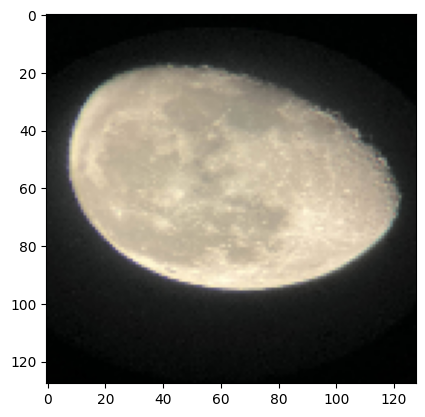

In [208]:
plt.imshow(array_jpg[80])

In [209]:
phase_names = ['First Quarter', 'Full Moon', 'Waning Gibbous','Waxing Crescent','Waxing Gibbous']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


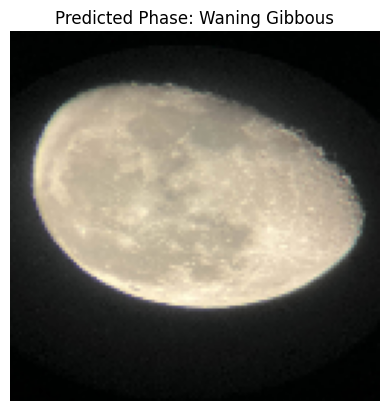

In [216]:
test_img = array_jpg[80]
test_pred = np.expand_dims(test_img, axis=0)
predicted_phase = phase_names[np.argmax(model.predict(test_pred))]

# Display image with predicted phase as a label
plt.imshow(test_img)
plt.title(f"Predicted Phase: {predicted_phase}")
plt.axis('off')  # Hide axes
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


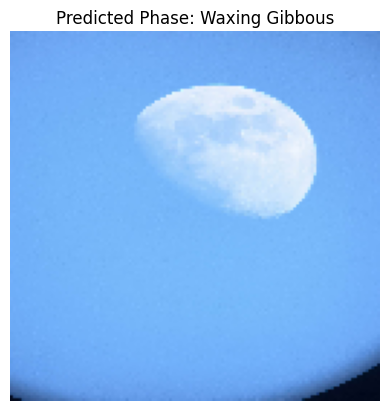

In [215]:
test_img = array_jpg[134]
test_pred = np.expand_dims(test_img, axis=0)
predicted_phase = phase_names[np.argmax(model.predict(test_pred))]

# Display image with predicted phase as a label
plt.imshow(test_img)
plt.title(f"Predicted Phase: {predicted_phase}")
plt.axis('off')  # Hide axes
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


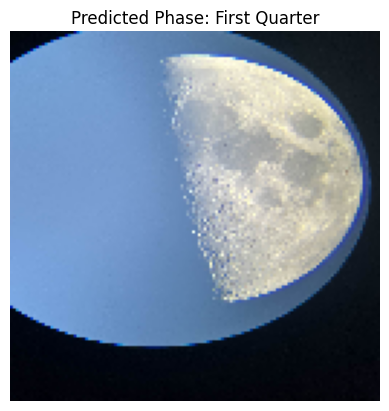

In [214]:
test_img = array_jpg[10]
test_pred = np.expand_dims(test_img, axis=0)
predicted_phase = phase_names[np.argmax(model.predict(test_pred))]

# Display image with predicted phase as a label
plt.imshow(test_img)
plt.title(f"Predicted Phase: {predicted_phase}")
plt.axis('off')  # Hide axes
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


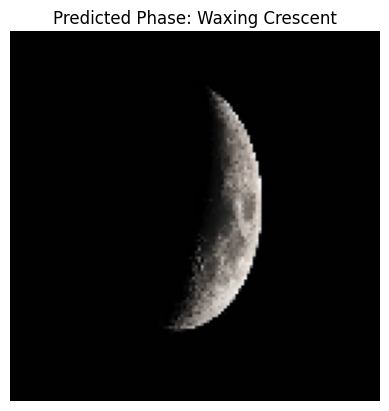

In [213]:
test_img = array_jpg[104]
test_pred = np.expand_dims(test_img, axis=0)
predicted_phase = phase_names[np.argmax(model.predict(test_pred))]

# Display image with predicted phase as a label
plt.imshow(test_img)
plt.title(f"Predicted Phase: {predicted_phase}")
plt.axis('off')  # Hide axes
plt.show()